# Train GAN / Discriminator part

In [1]:
import logging
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import torch
import torch.nn
from torch.nn import functional as F
import seaborn as sns
import random

import importlib
import toylosses
importlib.reload(toylosses)
import toynn
importlib.reload(toynn)
import toyvis
importlib.reload(toyvis)

sns.set()

DEVICE = 'cuda'

logging.basicConfig(
        format='%(asctime)s %(name)-12s %(levelname)-8s %(message)s',
        level=logging.INFO)
logging.getLogger().setLevel(logging.INFO)
logging.info('start')

2019-05-02 20:40:51,061 root         INFO     start


In [2]:
def train_gan(epoch, train_loader, modules, optimizers):
    for module in modules.values():
        module.train()
 
    total_loss_discriminator = 0
    total_loss_generator = 0
    total_loss = 0

    n_data = len(train_loader.dataset)
    n_batches = len(train_loader)

    for batch_idx, batch_data in enumerate(train_loader):
        if DEBUG and batch_idx > 3:
            continue

        batch_data = batch_data[0].to(DEVICE)
        n_batch_data = len(batch_data)

        for optimizer in optimizers.values():
                optimizer.zero_grad()

        decoder = modules['decoder']

        z_from_prior = toynn.sample_from_prior(
                    LATENT_DIM, n_samples=n_batch_data).to(DEVICE)
        batch_from_prior, batch_logvarx_from_prior = decoder(
                    z_from_prior)

        discriminator = modules['discriminator']

        real_labels = torch.full((n_batch_data, 1), 1, device=DEVICE)
        fake_labels = torch.full((n_batch_data, 1), 0, device=DEVICE)
        #noise_for_real_labels = np.random.normal(loc=0, scale=0.1, size=(n_batch_data, 1))
        #noise_for_fake_labels = np.random.normal(loc=0, scale=0.1, size=(n_batch_data, 1))
        #real_labels = real_labels - torch.Tensor(np.abs(noise_for_real_labels)).to(DEVICE)
        #fake_labels = fake_labels + torch.Tensor(np.abs(noise_for_fake_labels)).to(DEVICE)
        
        #noise_for_data = np.random.normal(loc=0, scale=2, size=(n_batch_data, 1))
        #noise_for_prior = np.random.normal(loc=0, scale=2, size=(n_batch_data, 1))
        noisy_batch_data = batch_data #+ torch.Tensor(noise_for_data).to(DEVICE)
        noisy_batch_from_prior = batch_from_prior #+ torch.Tensor(noise_for_prior).to(DEVICE)

        labels_data = discriminator(noisy_batch_data)
        labels_from_prior = discriminator(noisy_batch_from_prior)

        
        criterion = torch.nn.BCELoss()
        
        loss_dis_data = criterion(
                        labels_data,
                        real_labels)
        loss_dis_from_prior = criterion(
                        labels_from_prior,
                        fake_labels)

        loss_discriminator = (
                    loss_dis_data + loss_dis_from_prior)

        loss_discriminator.backward(retain_graph=True)
        #logging.info('Discriminator gradients')
        #for name, param in discriminator.named_parameters():
            #logging.info(name)
            #logging.info(param.grad)
        
        optimizers['discriminator'].step()

        loss_generator = criterion(
                    labels_from_prior,
                    real_labels)
        loss_generator.backward()
        
        #logging.info('Decoder gradients')
        #for name, param in decoder.named_parameters():
            #logging.info(name)
            #logging.info(param.grad)

        optimizers['decoder'].step()

        loss = loss_discriminator + loss_generator

        if batch_idx % PRINT_INTERVAL == 0:
            batch_loss = loss / n_batch_data
            batch_loss_discriminator = loss_discriminator / n_batch_data
            batch_loss_generator = loss_generator / n_batch_data

            dx = labels_data.mean()
            dgz = labels_from_prior.mean()

            string_base = (
                    'Train Epoch: {} [{}/{} ({:.0f}%)]\tTotal Loss: {:.6f}'
                    ', Discriminator: {:.6f}; Generator: {:.6f},'
                    '\nD(x): {:.3f}, D(G(z)): {:.3f}')
            logging.info(
                    string_base.format(
                        epoch, batch_idx * n_batch_data, n_data,
                        100. * batch_idx / n_batches,
                        batch_loss,
                        batch_loss_discriminator,
                        batch_loss_generator,
                        dx, dgz))

        total_loss_discriminator += loss_discriminator.item()
        total_loss_generator += loss_generator.item()

        total_loss += loss.item()

    average_loss = total_loss / n_data

    logging.info('====> Epoch: {} Average loss: {:.4f}'.format(
                epoch, average_loss))
    
    train_losses = {}
    train_losses['total'] = average_loss
    return train_losses

# Generate data

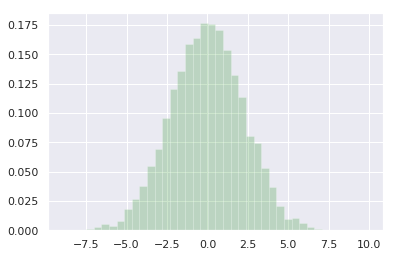

In [3]:
w_true = 2
color_true = 'green'

def generate_synthetic_1d(w=w_true, n=10):
    z = np.random.normal(loc=0, scale=1, size=(n, 1))
    eps = np.random.normal(loc=0, scale=1, size=(n, 1))

    x = w * z + eps
    return x

dataset = generate_synthetic_1d(w=w_true, n=10000)
fig, ax = plt.subplots()
ax = toyvis.plot_data(dataset, color=color_true, label='from decoder true', ax=ax)

# Initialize decoder

In [4]:
DEBUG = False

CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if CUDA else "cpu")

# Seed
SEED = 12345
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

DATA_DIM = 1
LATENT_DIM = 1
N_DECODER_LAYERS = 1
NONLINEARITY = False
N_SAMPLES = 10000
WITH_BIASX = False
WITH_LOGVARX = False
WITH_BIASZ = False
WITH_LOGVARZ = False

FRAC_TEST = 0.2
BATCH_SIZE = 32
KWARGS = {'num_workers': 1, 'pin_memory': True} if CUDA else {}

PRINT_INTERVAL = 16
torch.backends.cudnn.benchmark = True

N_EPOCHS = 50
LR = 1e-3

BETA1 = 0.5
BETA2 = 0.999

In [5]:
logging.info('--Dataset tensor: (%d, %d)' % dataset.shape)

n_train = int((1 - FRAC_TEST) * N_SAMPLES)
train = torch.Tensor(dataset[:n_train, :])

logging.info('-- Train tensor: (%d, %d)' % train.shape)
train_dataset = torch.utils.data.TensorDataset(train)
train_loader = torch.utils.data.DataLoader(
train_dataset, batch_size=BATCH_SIZE, shuffle=True, **KWARGS)

decoder = toynn.Decoder(
            latent_dim=LATENT_DIM,
            data_dim=DATA_DIM,
            n_layers=N_DECODER_LAYERS,
            nonlinearity=NONLINEARITY,
            with_biasx=WITH_BIASX,
            with_logvarx=WITH_LOGVARX).to(DEVICE)

# Set the value of the decoder to the biased value we know happens

decoder.layers[0].weight.data = torch.tensor([[1.10]]).to(DEVICE)

discriminator = toynn.Discriminator(data_dim=DATA_DIM).to(DEVICE)

modules = {}
modules['decoder'] = decoder
modules['discriminator'] = discriminator

logging.info('Values of VAE\'s decoder parameters before training:')
for name, param in decoder.named_parameters():
    logging.info(name)
    logging.info(param.data)

optimizers = {}
optimizers['decoder'] = torch.optim.Adam(
    modules['decoder'].parameters(), lr=LR, betas=(BETA1, BETA2))
optimizers['discriminator'] = torch.optim.SGD(
    modules['discriminator'].parameters(), lr=LR)


def init_xavier_normal(m):
    if type(m) == tnn.Linear:
        tnn.init.xavier_normal_(m.weight)

    for module in modules.values():
        module.apply(init_xavier_normal)

train_losses_all_epochs = []

for epoch in range(N_EPOCHS):
    if DEBUG:
        if epoch > 2:
            break

    train_losses = train_gan(
                epoch, train_loader, modules, optimizers)
    train_losses_all_epochs.append(train_losses)

2019-05-02 20:40:51,297 root         INFO     --Dataset tensor: (10000, 1)
2019-05-02 20:40:51,298 root         INFO     -- Train tensor: (8000, 1)
2019-05-02 20:40:53,092 root         INFO     Values of VAE's decoder parameters before training:
2019-05-02 20:40:53,093 root         INFO     layers.0.weight
2019-05-02 20:40:53,093 root         INFO     tensor([[1.1000]], device='cuda:0')
2019-05-02 20:40:53,136 root         INFO     Train Epoch: 0 [0/8000 (0%)]	Total Loss: 0.084263, Discriminator: 0.048007; Generator: 0.036256,
D(x): 0.313, D(G(z)): 0.313
2019-05-02 20:40:53,194 root         INFO     Train Epoch: 0 [512/8000 (6%)]	Total Loss: 0.084053, Discriminator: 0.047933; Generator: 0.036119,
D(x): 0.315, D(G(z)): 0.315
2019-05-02 20:40:53,251 root         INFO     Train Epoch: 0 [1024/8000 (13%)]	Total Loss: 0.083845, Discriminator: 0.047860; Generator: 0.035984,
D(x): 0.316, D(G(z)): 0.316
2019-05-02 20:40:53,308 root         INFO     Train Epoch: 0 [1536/8000 (19%)]	Total Loss: 

2019-05-02 20:40:55,792 root         INFO     Train Epoch: 2 [6144/8000 (77%)]	Total Loss: 0.076952, Discriminator: 0.045619; Generator: 0.031334,
D(x): 0.367, D(G(z)): 0.367
2019-05-02 20:40:55,851 root         INFO     Train Epoch: 2 [6656/8000 (83%)]	Total Loss: 0.076821, Discriminator: 0.045580; Generator: 0.031241,
D(x): 0.368, D(G(z)): 0.368
2019-05-02 20:40:55,910 root         INFO     Train Epoch: 2 [7168/8000 (90%)]	Total Loss: 0.076690, Discriminator: 0.045542; Generator: 0.031149,
D(x): 0.369, D(G(z)): 0.369
2019-05-02 20:40:55,969 root         INFO     Train Epoch: 2 [7680/8000 (96%)]	Total Loss: 0.076562, Discriminator: 0.045504; Generator: 0.031058,
D(x): 0.370, D(G(z)): 0.370
2019-05-02 20:40:56,031 root         INFO     ====> Epoch: 2 Average loss: 0.0775
2019-05-02 20:40:56,068 root         INFO     Train Epoch: 3 [0/8000 (0%)]	Total Loss: 0.076482, Discriminator: 0.045481; Generator: 0.031001,
D(x): 0.371, D(G(z)): 0.371
2019-05-02 20:40:56,129 root         INFO     T

2019-05-02 20:40:58,576 root         INFO     Train Epoch: 5 [5120/8000 (64%)]	Total Loss: 0.072271, Discriminator: 0.044364; Generator: 0.027907,
D(x): 0.409, D(G(z)): 0.409
2019-05-02 20:40:58,633 root         INFO     Train Epoch: 5 [5632/8000 (70%)]	Total Loss: 0.072191, Discriminator: 0.044346; Generator: 0.027845,
D(x): 0.410, D(G(z)): 0.410
2019-05-02 20:40:58,690 root         INFO     Train Epoch: 5 [6144/8000 (77%)]	Total Loss: 0.072112, Discriminator: 0.044327; Generator: 0.027785,
D(x): 0.411, D(G(z)): 0.411
2019-05-02 20:40:58,747 root         INFO     Train Epoch: 5 [6656/8000 (83%)]	Total Loss: 0.072034, Discriminator: 0.044309; Generator: 0.027725,
D(x): 0.412, D(G(z)): 0.412
2019-05-02 20:40:58,804 root         INFO     Train Epoch: 5 [7168/8000 (90%)]	Total Loss: 0.071957, Discriminator: 0.044292; Generator: 0.027665,
D(x): 0.413, D(G(z)): 0.413
2019-05-02 20:40:58,862 root         INFO     Train Epoch: 5 [7680/8000 (96%)]	Total Loss: 0.071880, Discriminator: 0.044274;

2019-05-02 20:41:01,365 root         INFO     Train Epoch: 8 [4096/8000 (51%)]	Total Loss: 0.069436, Discriminator: 0.043776; Generator: 0.025660,
D(x): 0.440, D(G(z)): 0.440
2019-05-02 20:41:01,421 root         INFO     Train Epoch: 8 [4608/8000 (58%)]	Total Loss: 0.069388, Discriminator: 0.043767; Generator: 0.025620,
D(x): 0.440, D(G(z)): 0.440
2019-05-02 20:41:01,477 root         INFO     Train Epoch: 8 [5120/8000 (64%)]	Total Loss: 0.069340, Discriminator: 0.043759; Generator: 0.025581,
D(x): 0.441, D(G(z)): 0.441
2019-05-02 20:41:01,533 root         INFO     Train Epoch: 8 [5632/8000 (70%)]	Total Loss: 0.069293, Discriminator: 0.043751; Generator: 0.025542,
D(x): 0.442, D(G(z)): 0.442
2019-05-02 20:41:01,590 root         INFO     Train Epoch: 8 [6144/8000 (77%)]	Total Loss: 0.069246, Discriminator: 0.043743; Generator: 0.025503,
D(x): 0.442, D(G(z)): 0.442
2019-05-02 20:41:01,646 root         INFO     Train Epoch: 8 [6656/8000 (83%)]	Total Loss: 0.069200, Discriminator: 0.043735;

2019-05-02 20:41:04,114 root         INFO     Train Epoch: 11 [3072/8000 (38%)]	Total Loss: 0.067719, Discriminator: 0.043513; Generator: 0.024206,
D(x): 0.461, D(G(z)): 0.461
2019-05-02 20:41:04,172 root         INFO     Train Epoch: 11 [3584/8000 (45%)]	Total Loss: 0.067690, Discriminator: 0.043510; Generator: 0.024180,
D(x): 0.461, D(G(z)): 0.461
2019-05-02 20:41:04,229 root         INFO     Train Epoch: 11 [4096/8000 (51%)]	Total Loss: 0.067661, Discriminator: 0.043506; Generator: 0.024155,
D(x): 0.462, D(G(z)): 0.462
2019-05-02 20:41:04,286 root         INFO     Train Epoch: 11 [4608/8000 (58%)]	Total Loss: 0.067632, Discriminator: 0.043503; Generator: 0.024130,
D(x): 0.462, D(G(z)): 0.462
2019-05-02 20:41:04,343 root         INFO     Train Epoch: 11 [5120/8000 (64%)]	Total Loss: 0.067604, Discriminator: 0.043499; Generator: 0.024105,
D(x): 0.462, D(G(z)): 0.462
2019-05-02 20:41:04,400 root         INFO     Train Epoch: 11 [5632/8000 (70%)]	Total Loss: 0.067576, Discriminator: 0.0

2019-05-02 20:41:06,872 root         INFO     Train Epoch: 14 [2048/8000 (26%)]	Total Loss: 0.066674, Discriminator: 0.043401; Generator: 0.023273,
D(x): 0.475, D(G(z)): 0.475
2019-05-02 20:41:06,929 root         INFO     Train Epoch: 14 [2560/8000 (32%)]	Total Loss: 0.066656, Discriminator: 0.043399; Generator: 0.023257,
D(x): 0.475, D(G(z)): 0.475
2019-05-02 20:41:06,985 root         INFO     Train Epoch: 14 [3072/8000 (38%)]	Total Loss: 0.066638, Discriminator: 0.043398; Generator: 0.023241,
D(x): 0.475, D(G(z)): 0.475
2019-05-02 20:41:07,042 root         INFO     Train Epoch: 14 [3584/8000 (45%)]	Total Loss: 0.066621, Discriminator: 0.043396; Generator: 0.023225,
D(x): 0.476, D(G(z)): 0.476
2019-05-02 20:41:07,098 root         INFO     Train Epoch: 14 [4096/8000 (51%)]	Total Loss: 0.066604, Discriminator: 0.043395; Generator: 0.023209,
D(x): 0.476, D(G(z)): 0.476
2019-05-02 20:41:07,154 root         INFO     Train Epoch: 14 [4608/8000 (58%)]	Total Loss: 0.066586, Discriminator: 0.0

2019-05-02 20:41:09,630 root         INFO     Train Epoch: 17 [1024/8000 (13%)]	Total Loss: 0.066033, Discriminator: 0.043354; Generator: 0.022679,
D(x): 0.484, D(G(z)): 0.484
2019-05-02 20:41:09,687 root         INFO     Train Epoch: 17 [1536/8000 (19%)]	Total Loss: 0.066022, Discriminator: 0.043353; Generator: 0.022669,
D(x): 0.484, D(G(z)): 0.484
2019-05-02 20:41:09,744 root         INFO     Train Epoch: 17 [2048/8000 (26%)]	Total Loss: 0.066011, Discriminator: 0.043353; Generator: 0.022659,
D(x): 0.484, D(G(z)): 0.484
2019-05-02 20:41:09,801 root         INFO     Train Epoch: 17 [2560/8000 (32%)]	Total Loss: 0.066000, Discriminator: 0.043352; Generator: 0.022648,
D(x): 0.484, D(G(z)): 0.484
2019-05-02 20:41:09,858 root         INFO     Train Epoch: 17 [3072/8000 (38%)]	Total Loss: 0.065990, Discriminator: 0.043351; Generator: 0.022638,
D(x): 0.485, D(G(z)): 0.485
2019-05-02 20:41:09,916 root         INFO     Train Epoch: 17 [3584/8000 (45%)]	Total Loss: 0.065979, Discriminator: 0.0

2019-05-02 20:41:12,382 root         INFO     ====> Epoch: 19 Average loss: 0.0657
2019-05-02 20:41:12,420 root         INFO     Train Epoch: 20 [0/8000 (0%)]	Total Loss: 0.065637, Discriminator: 0.043335; Generator: 0.022303,
D(x): 0.490, D(G(z)): 0.490
2019-05-02 20:41:12,478 root         INFO     Train Epoch: 20 [512/8000 (6%)]	Total Loss: 0.065631, Discriminator: 0.043334; Generator: 0.022296,
D(x): 0.490, D(G(z)): 0.490
2019-05-02 20:41:12,536 root         INFO     Train Epoch: 20 [1024/8000 (13%)]	Total Loss: 0.065624, Discriminator: 0.043334; Generator: 0.022290,
D(x): 0.490, D(G(z)): 0.490
2019-05-02 20:41:12,594 root         INFO     Train Epoch: 20 [1536/8000 (19%)]	Total Loss: 0.065617, Discriminator: 0.043334; Generator: 0.022283,
D(x): 0.490, D(G(z)): 0.490
2019-05-02 20:41:12,650 root         INFO     Train Epoch: 20 [2048/8000 (26%)]	Total Loss: 0.065611, Discriminator: 0.043334; Generator: 0.022277,
D(x): 0.490, D(G(z)): 0.490
2019-05-02 20:41:12,707 root         INFO  

2019-05-02 20:41:15,158 root         INFO     Train Epoch: 22 [7168/8000 (90%)]	Total Loss: 0.065390, Discriminator: 0.043327; Generator: 0.022063,
D(x): 0.494, D(G(z)): 0.494
2019-05-02 20:41:15,218 root         INFO     Train Epoch: 22 [7680/8000 (96%)]	Total Loss: 0.065386, Discriminator: 0.043327; Generator: 0.022059,
D(x): 0.494, D(G(z)): 0.494
2019-05-02 20:41:15,281 root         INFO     ====> Epoch: 22 Average loss: 0.0654
2019-05-02 20:41:15,317 root         INFO     Train Epoch: 23 [0/8000 (0%)]	Total Loss: 0.065383, Discriminator: 0.043327; Generator: 0.022057,
D(x): 0.494, D(G(z)): 0.494
2019-05-02 20:41:15,376 root         INFO     Train Epoch: 23 [512/8000 (6%)]	Total Loss: 0.065379, Discriminator: 0.043327; Generator: 0.022053,
D(x): 0.494, D(G(z)): 0.494
2019-05-02 20:41:15,433 root         INFO     Train Epoch: 23 [1024/8000 (13%)]	Total Loss: 0.065375, Discriminator: 0.043326; Generator: 0.022049,
D(x): 0.494, D(G(z)): 0.494
2019-05-02 20:41:15,491 root         INFO  

2019-05-02 20:41:17,959 root         INFO     Train Epoch: 25 [6144/8000 (77%)]	Total Loss: 0.065238, Discriminator: 0.043324; Generator: 0.021914,
D(x): 0.496, D(G(z)): 0.496
2019-05-02 20:41:18,016 root         INFO     Train Epoch: 25 [6656/8000 (83%)]	Total Loss: 0.065235, Discriminator: 0.043324; Generator: 0.021911,
D(x): 0.496, D(G(z)): 0.496
2019-05-02 20:41:18,074 root         INFO     Train Epoch: 25 [7168/8000 (90%)]	Total Loss: 0.065233, Discriminator: 0.043324; Generator: 0.021909,
D(x): 0.496, D(G(z)): 0.496
2019-05-02 20:41:18,132 root         INFO     Train Epoch: 25 [7680/8000 (96%)]	Total Loss: 0.065230, Discriminator: 0.043324; Generator: 0.021906,
D(x): 0.496, D(G(z)): 0.496
2019-05-02 20:41:18,193 root         INFO     ====> Epoch: 25 Average loss: 0.0652
2019-05-02 20:41:18,229 root         INFO     Train Epoch: 26 [0/8000 (0%)]	Total Loss: 0.065228, Discriminator: 0.043324; Generator: 0.021905,
D(x): 0.496, D(G(z)): 0.496
2019-05-02 20:41:18,289 root         INFO

2019-05-02 20:41:20,748 root         INFO     Train Epoch: 28 [5120/8000 (64%)]	Total Loss: 0.065143, Discriminator: 0.043323; Generator: 0.021820,
D(x): 0.497, D(G(z)): 0.497
2019-05-02 20:41:20,810 root         INFO     Train Epoch: 28 [5632/8000 (70%)]	Total Loss: 0.065141, Discriminator: 0.043322; Generator: 0.021818,
D(x): 0.497, D(G(z)): 0.497
2019-05-02 20:41:20,871 root         INFO     Train Epoch: 28 [6144/8000 (77%)]	Total Loss: 0.065139, Discriminator: 0.043322; Generator: 0.021817,
D(x): 0.498, D(G(z)): 0.498
2019-05-02 20:41:20,933 root         INFO     Train Epoch: 28 [6656/8000 (83%)]	Total Loss: 0.065138, Discriminator: 0.043322; Generator: 0.021815,
D(x): 0.498, D(G(z)): 0.498
2019-05-02 20:41:20,995 root         INFO     Train Epoch: 28 [7168/8000 (90%)]	Total Loss: 0.065136, Discriminator: 0.043322; Generator: 0.021814,
D(x): 0.498, D(G(z)): 0.498
2019-05-02 20:41:21,057 root         INFO     Train Epoch: 28 [7680/8000 (96%)]	Total Loss: 0.065134, Discriminator: 0.0

2019-05-02 20:41:23,590 root         INFO     Train Epoch: 31 [4096/8000 (51%)]	Total Loss: 0.065083, Discriminator: 0.043322; Generator: 0.021761,
D(x): 0.498, D(G(z)): 0.498
2019-05-02 20:41:23,653 root         INFO     Train Epoch: 31 [4608/8000 (58%)]	Total Loss: 0.065082, Discriminator: 0.043322; Generator: 0.021760,
D(x): 0.498, D(G(z)): 0.498
2019-05-02 20:41:23,717 root         INFO     Train Epoch: 31 [5120/8000 (64%)]	Total Loss: 0.065081, Discriminator: 0.043322; Generator: 0.021759,
D(x): 0.498, D(G(z)): 0.498
2019-05-02 20:41:23,780 root         INFO     Train Epoch: 31 [5632/8000 (70%)]	Total Loss: 0.065080, Discriminator: 0.043322; Generator: 0.021758,
D(x): 0.498, D(G(z)): 0.498
2019-05-02 20:41:23,844 root         INFO     Train Epoch: 31 [6144/8000 (77%)]	Total Loss: 0.065079, Discriminator: 0.043322; Generator: 0.021757,
D(x): 0.498, D(G(z)): 0.498
2019-05-02 20:41:23,907 root         INFO     Train Epoch: 31 [6656/8000 (83%)]	Total Loss: 0.065078, Discriminator: 0.0

2019-05-02 20:41:26,441 root         INFO     Train Epoch: 34 [3072/8000 (38%)]	Total Loss: 0.065046, Discriminator: 0.043322; Generator: 0.021724,
D(x): 0.499, D(G(z)): 0.499
2019-05-02 20:41:26,500 root         INFO     Train Epoch: 34 [3584/8000 (45%)]	Total Loss: 0.065045, Discriminator: 0.043322; Generator: 0.021723,
D(x): 0.499, D(G(z)): 0.499
2019-05-02 20:41:26,560 root         INFO     Train Epoch: 34 [4096/8000 (51%)]	Total Loss: 0.065044, Discriminator: 0.043322; Generator: 0.021722,
D(x): 0.499, D(G(z)): 0.499
2019-05-02 20:41:26,619 root         INFO     Train Epoch: 34 [4608/8000 (58%)]	Total Loss: 0.065044, Discriminator: 0.043322; Generator: 0.021722,
D(x): 0.499, D(G(z)): 0.499
2019-05-02 20:41:26,676 root         INFO     Train Epoch: 34 [5120/8000 (64%)]	Total Loss: 0.065043, Discriminator: 0.043322; Generator: 0.021721,
D(x): 0.499, D(G(z)): 0.499
2019-05-02 20:41:26,732 root         INFO     Train Epoch: 34 [5632/8000 (70%)]	Total Loss: 0.065042, Discriminator: 0.0

2019-05-02 20:41:29,200 root         INFO     Train Epoch: 37 [2048/8000 (26%)]	Total Loss: 0.065022, Discriminator: 0.043322; Generator: 0.021700,
D(x): 0.499, D(G(z)): 0.499
2019-05-02 20:41:29,259 root         INFO     Train Epoch: 37 [2560/8000 (32%)]	Total Loss: 0.065022, Discriminator: 0.043322; Generator: 0.021700,
D(x): 0.499, D(G(z)): 0.499
2019-05-02 20:41:29,316 root         INFO     Train Epoch: 37 [3072/8000 (38%)]	Total Loss: 0.065021, Discriminator: 0.043322; Generator: 0.021700,
D(x): 0.499, D(G(z)): 0.499
2019-05-02 20:41:29,374 root         INFO     Train Epoch: 37 [3584/8000 (45%)]	Total Loss: 0.065021, Discriminator: 0.043322; Generator: 0.021699,
D(x): 0.499, D(G(z)): 0.499
2019-05-02 20:41:29,433 root         INFO     Train Epoch: 37 [4096/8000 (51%)]	Total Loss: 0.065020, Discriminator: 0.043322; Generator: 0.021699,
D(x): 0.499, D(G(z)): 0.499
2019-05-02 20:41:29,491 root         INFO     Train Epoch: 37 [4608/8000 (58%)]	Total Loss: 0.065020, Discriminator: 0.0

2019-05-02 20:41:31,980 root         INFO     Train Epoch: 40 [1024/8000 (13%)]	Total Loss: 0.065007, Discriminator: 0.043322; Generator: 0.021686,
D(x): 0.500, D(G(z)): 0.500
2019-05-02 20:41:32,038 root         INFO     Train Epoch: 40 [1536/8000 (19%)]	Total Loss: 0.065007, Discriminator: 0.043322; Generator: 0.021685,
D(x): 0.500, D(G(z)): 0.500
2019-05-02 20:41:32,096 root         INFO     Train Epoch: 40 [2048/8000 (26%)]	Total Loss: 0.065007, Discriminator: 0.043322; Generator: 0.021685,
D(x): 0.500, D(G(z)): 0.500
2019-05-02 20:41:32,156 root         INFO     Train Epoch: 40 [2560/8000 (32%)]	Total Loss: 0.065007, Discriminator: 0.043322; Generator: 0.021685,
D(x): 0.500, D(G(z)): 0.500
2019-05-02 20:41:32,214 root         INFO     Train Epoch: 40 [3072/8000 (38%)]	Total Loss: 0.065006, Discriminator: 0.043322; Generator: 0.021685,
D(x): 0.500, D(G(z)): 0.500
2019-05-02 20:41:32,273 root         INFO     Train Epoch: 40 [3584/8000 (45%)]	Total Loss: 0.065006, Discriminator: 0.0

2019-05-02 20:41:34,742 root         INFO     ====> Epoch: 42 Average loss: 0.0650
2019-05-02 20:41:34,778 root         INFO     Train Epoch: 43 [0/8000 (0%)]	Total Loss: 0.064998, Discriminator: 0.043322; Generator: 0.021676,
D(x): 0.500, D(G(z)): 0.500
2019-05-02 20:41:34,837 root         INFO     Train Epoch: 43 [512/8000 (6%)]	Total Loss: 0.064998, Discriminator: 0.043322; Generator: 0.021676,
D(x): 0.500, D(G(z)): 0.500
2019-05-02 20:41:34,896 root         INFO     Train Epoch: 43 [1024/8000 (13%)]	Total Loss: 0.064998, Discriminator: 0.043322; Generator: 0.021676,
D(x): 0.500, D(G(z)): 0.500
2019-05-02 20:41:34,954 root         INFO     Train Epoch: 43 [1536/8000 (19%)]	Total Loss: 0.064998, Discriminator: 0.043322; Generator: 0.021676,
D(x): 0.500, D(G(z)): 0.500
2019-05-02 20:41:35,013 root         INFO     Train Epoch: 43 [2048/8000 (26%)]	Total Loss: 0.064997, Discriminator: 0.043322; Generator: 0.021676,
D(x): 0.500, D(G(z)): 0.500
2019-05-02 20:41:35,071 root         INFO  

2019-05-02 20:41:37,544 root         INFO     Train Epoch: 45 [7168/8000 (90%)]	Total Loss: 0.064992, Discriminator: 0.043322; Generator: 0.021671,
D(x): 0.500, D(G(z)): 0.500
2019-05-02 20:41:37,601 root         INFO     Train Epoch: 45 [7680/8000 (96%)]	Total Loss: 0.064992, Discriminator: 0.043322; Generator: 0.021670,
D(x): 0.500, D(G(z)): 0.500
2019-05-02 20:41:37,663 root         INFO     ====> Epoch: 45 Average loss: 0.0650
2019-05-02 20:41:37,698 root         INFO     Train Epoch: 46 [0/8000 (0%)]	Total Loss: 0.064992, Discriminator: 0.043322; Generator: 0.021670,
D(x): 0.500, D(G(z)): 0.500
2019-05-02 20:41:37,757 root         INFO     Train Epoch: 46 [512/8000 (6%)]	Total Loss: 0.064992, Discriminator: 0.043322; Generator: 0.021670,
D(x): 0.500, D(G(z)): 0.500
2019-05-02 20:41:37,815 root         INFO     Train Epoch: 46 [1024/8000 (13%)]	Total Loss: 0.064992, Discriminator: 0.043322; Generator: 0.021670,
D(x): 0.500, D(G(z)): 0.500
2019-05-02 20:41:37,872 root         INFO  

2019-05-02 20:41:40,313 root         INFO     Train Epoch: 48 [6144/8000 (77%)]	Total Loss: 0.064989, Discriminator: 0.043322; Generator: 0.021667,
D(x): 0.500, D(G(z)): 0.500
2019-05-02 20:41:40,372 root         INFO     Train Epoch: 48 [6656/8000 (83%)]	Total Loss: 0.064989, Discriminator: 0.043322; Generator: 0.021667,
D(x): 0.500, D(G(z)): 0.500
2019-05-02 20:41:40,429 root         INFO     Train Epoch: 48 [7168/8000 (90%)]	Total Loss: 0.064989, Discriminator: 0.043322; Generator: 0.021667,
D(x): 0.500, D(G(z)): 0.500
2019-05-02 20:41:40,487 root         INFO     Train Epoch: 48 [7680/8000 (96%)]	Total Loss: 0.064988, Discriminator: 0.043322; Generator: 0.021667,
D(x): 0.500, D(G(z)): 0.500
2019-05-02 20:41:40,549 root         INFO     ====> Epoch: 48 Average loss: 0.0650
2019-05-02 20:41:40,585 root         INFO     Train Epoch: 49 [0/8000 (0%)]	Total Loss: 0.064988, Discriminator: 0.043322; Generator: 0.021667,
D(x): 0.500, D(G(z)): 0.500
2019-05-02 20:41:40,644 root         INFO

2019-05-02 20:41:41,545 root         INFO     Values of VAE's decoder parameters after training:
2019-05-02 20:41:41,545 root         INFO     layers.0.weight
2019-05-02 20:41:41,545 root         INFO     tensor([[1.1362]], device='cuda:0')


Last losses:
[0.0649929473400116, 0.06499139633774757, 0.06499006834626198, 0.06498894593119621, 0.06498799261450768]
1.1362075


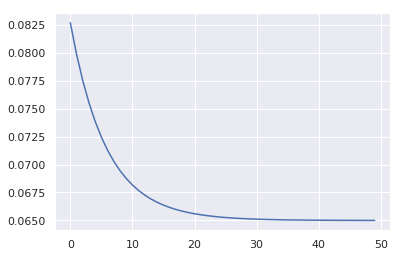

In [6]:
plt.figure()
train_losses_total = [loss['total'] for loss in train_losses_all_epochs]
n_epochs = len(train_losses_total)
plt.plot(range(n_epochs), train_losses_total)
print('Last losses:')
print(train_losses_total[-5:])

logging.info('Values of VAE\'s decoder parameters after training:')
for name, param in decoder.named_parameters():
    logging.info(name)
    logging.info(param.data)
    w_learnt = param.data[0,0].cpu().numpy()
print(w_learnt)

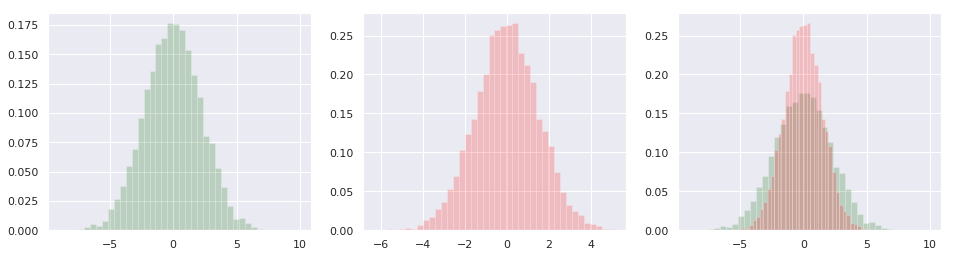

In [7]:
n_samples = 10000
#generated_x = toynn.generate_from_decoder(decoder, n_samples)
generated_x = generate_synthetic_1d(w=w_learnt, n=n_samples)
                                    
# For 1D
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(16, 4))
axis_side = 20

ax = axes[0]
toyvis.plot_data(dataset, color='darkgreen', ax=ax)

ax = axes[1]
toyvis.plot_data(generated_x, color='red', ax=ax)

ax = axes[2]
toyvis.plot_data(dataset, color='darkgreen', ax=ax, label='true')
toyvis.plot_data(generated_x, color='red', ax=ax, label='vae estimate')